# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования** - Построить модель, которая умеет определять рыночную стоимость автомобиля. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Описание данных.**
 - `DateCrawled` — дата скачивания анкеты из базы
 - `VehicleType` — тип автомобильного кузова
 - `RegistrationYear` — год регистрации автомобиля
 - `Gearbox` — тип коробки передач
 - `Power` — мощность (л. с.)
 - `Model` — модель автомобиля
 - `Kilometer` — пробег (км)
 - `RegistrationMonth` — месяц регистрации автомобиля
 - `FuelType` — тип топлива
 - `Brand` — марка автомобиля
 - `NotRepaired` — была машина в ремонте или нет
 - `DateCreated` — дата создания анкеты
 - `NumberOfPictures` — количество фотографий автомобиля
 - `PostalCode` — почтовый индекс владельца анкеты (пользователя)
 - `LastSeen` — дата последней активности пользователя

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
warnings.simplefilter("ignore")

In [2]:
try:
    df = pd.read_csv('/DS/Yandex_Practikum/Projects/datasets/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
#df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [4]:
df.describe(include='all')

date_crawled          price vehicle_type  registration_year  \
count                354369  354369.000000       316879      354369.000000   
unique               271174            NaN            8                NaN   
top     2016-03-24 14:49:47            NaN        sedan                NaN   
freq                      7            NaN        91457                NaN   
mean                    NaN    4416.656776          NaN        2004.234448   
std                     NaN    4514.158514          NaN          90.227958   
min                     NaN       0.000000          NaN        1000.000000   
25%                     NaN    1050.000000          NaN        1999.000000   
50%                     NaN    2700.000000          NaN        2003.000000   
75%                     NaN    6400.000000          NaN        2008.000000   
max                     NaN   20000.000000          NaN        9999.000000   

       gearbox          power   model      kilometer  registration_month  \
count   334536  354369.000000  334664  354369.000000       354369.000000   
unique       2            NaN     250            NaN                 NaN   
top     manual            NaN    golf            NaN                 NaN   
freq    268251            NaN   29232            NaN                 NaN   
mean       NaN     110.094337     NaN  128211.172535            5.714645   
std        NaN     189.850405     NaN   37905.341530            3.726421   
min        NaN       0.000000     NaN    5000.000000            0.000000   
25%        NaN      69.000000     NaN  125000.000000            3.000000   
50%        NaN     105.000000     NaN  150000.000000            6.000000   
75%        NaN     143.000000     NaN  150000.000000            9.000000   
max        NaN   20000.000000     NaN  150000.000000           12.000000   

       fuel_type       brand repaired         date_created  \
count     321474      354369   283215               354369   
unique         7          40        2                  109   
top       petrol  volkswagen       no  2016-04-03 00:00:00   
freq      216352       77013   247161                13719   
mean         NaN         NaN      NaN                  NaN   
std          NaN         NaN      NaN                  NaN   
min          NaN         NaN      NaN                  NaN   
25%          NaN         NaN      NaN                  NaN   
50%          NaN         NaN      NaN                  NaN   
75%          NaN         NaN      NaN                  NaN   
max          NaN         NaN      NaN                  NaN   

        number_of_pictures    postal_code            last_seen  
count             354369.0  354369.000000               354369  
unique                 NaN            NaN               179150  
top                    NaN            NaN  2016-04-06 13:45:54  
freq                   NaN            NaN                   17  
mean                   0.0   50508.689087                  NaN  
std                    0.0   25783.096248                  NaN  
min                    0.0    1067.000000                  NaN  
25%                    0.0   30165.000000                  NaN  
50%                    0.0   49413.000000                  NaN  
75%                    0.0   71083.000000                  NaN  
max                    0.0   99998.000000                  NaN

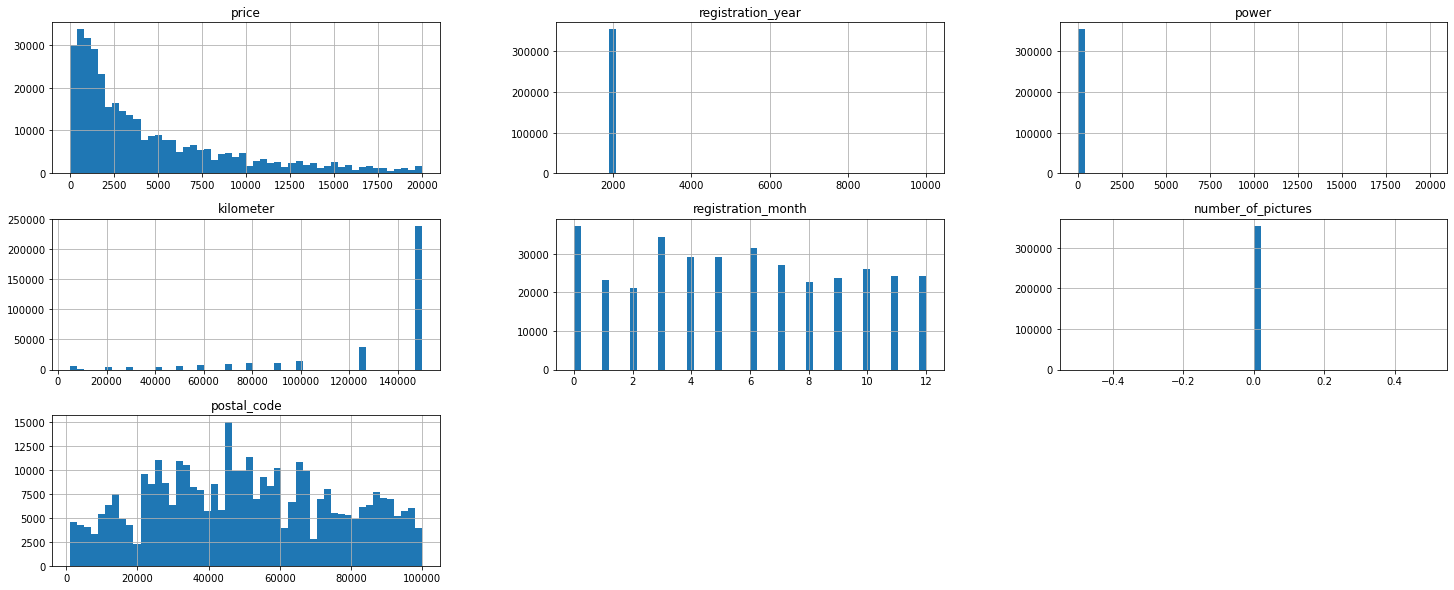

In [5]:
df.hist(bins = 50,figsize=(25,10))
plt.show()

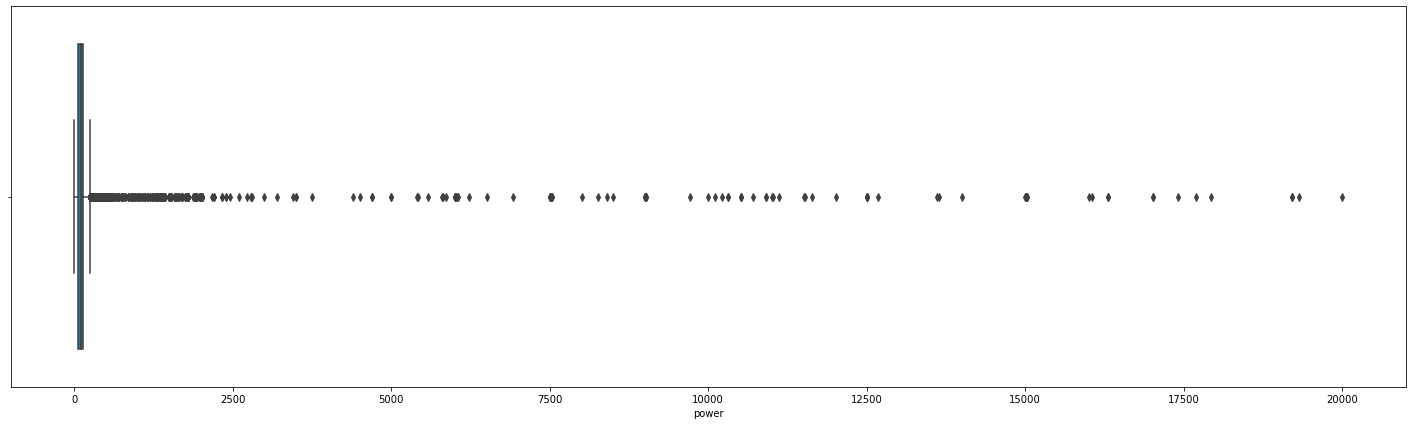

In [6]:
plt.figure(figsize=(25,7))
sns.boxplot(x=df['power'])
plt.show()

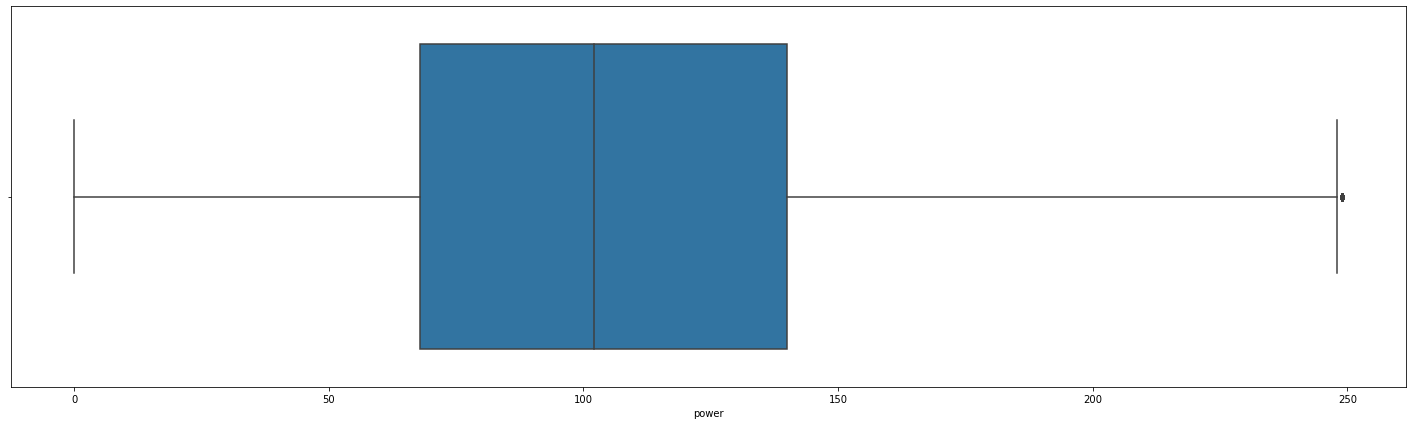

In [7]:
plt.figure(figsize=(25,7))
sns.boxplot(x=df.query('power < 250')['power'])
plt.show()

In [8]:
df.query('power > 250')

date_crawled  price vehicle_type  registration_year gearbox  \
41      2016-03-30 20:38:20   7500        sedan               2002    auto   
59      2016-03-29 15:48:15      1          suv               1994  manual   
113     2016-03-20 18:38:02   6300        sedan               2002  manual   
125     2016-03-11 20:55:37   1800        sedan               1995    auto   
172     2016-03-07 12:38:19  19750  convertible               2006  manual   
...                     ...    ...          ...                ...     ...   
354260  2016-03-09 17:59:03    399        other               1994     NaN   
354281  2016-03-07 05:58:24   6500        sedan               1993    auto   
354306  2016-04-02 23:25:40  16999        wagon               2008    auto   
354337  2016-03-26 14:38:18  11500        sedan               2004    auto   
354354  2016-03-25 18:48:06   5000        sedan               2003    auto   

        power     model  kilometer  registration_month fuel_type  \
41        306  e_klasse     150000                   4       NaN   
59        286       NaN     150000                  11       NaN   
113       265      golf     150000                   3    petrol   
125       286       7er     150000                  12    petrol   
172       305   mustang      50000                   7    petrol   
...       ...       ...        ...                 ...       ...   
354260   1103       3er     150000                   0       NaN   
354281    286       5er     150000                   1    petrol   
354306    269        a6     150000                   7  gasoline   
354337    445       7er     125000                   0    petrol   
354354    260  e_klasse     150000                  12  gasoline   

                 brand repaired         date_created  number_of_pictures  \
41       mercedes_benz      NaN  2016-03-30 00:00:00                   0   
59      sonstige_autos      NaN  2016-03-29 00:00:00                   0   
113         volkswagen       no  2016-03-20 00:00:00                   0   
125                bmw      yes  2016-03-11 00:00:00                   0   
172               ford       no  2016-03-07 00:00:00                   0   
...                ...      ...                  ...                 ...   
354260             bmw      NaN  2016-03-09 00:00:00                   0   
354281             bmw       no  2016-03-07 00:00:00                   0   
354306            audi       no  2016-04-02 00:00:00                   0   
354337             bmw      NaN  2016-03-26 00:00:00                   0   
354354   mercedes_benz      yes  2016-03-25 00:00:00                   0   

        postal_code            last_seen  
41            33649  2016-04-03 11:44:49  
59            53721  2016-04-06 01:44:38  
113           56759  2016-04-07 01:45:06  
125           77866  2016-03-20 10:17:59  
172           38350  2016-03-12 20:18:29  
...             ...                  ...  
354260        56235  2016-03-17 09:17:08  
354281        81249  2016-04-05 15:17:12  
354306        61440  2016-04-06 15:17:04  
354337         4107  2016-04-06 20:45:16  
354354        90473  2016-04-07 00:44:51  

[7453 rows x 16 columns]

In [9]:
print(f'Процент выбросов {7453 /df.shape[0]:.2%}')

Процент выбросов 2.10%


In [10]:
phik_overview = df.drop(['date_crawled','registration_month','date_created','postal_code','last_seen','number_of_pictures'], axis=1).phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


price  vehicle_type  registration_year  gearbox  power  \
price               1.00          0.27               0.01     0.32   0.01   
vehicle_type        0.27          1.00                NaN     0.29   0.01   
registration_year   0.01           NaN               1.00     0.00   0.09   
gearbox             0.32          0.29               0.00     1.00   0.01   
power               0.01          0.01               0.09     0.01   1.00   
model               0.58          0.92               0.08     0.65   0.00   
kilometer           0.31          0.17               0.23     0.02   0.00   
fuel_type           0.26          0.33               0.04     0.15   0.01   
brand               0.36          0.63               0.05     0.52   0.00   
repaired            0.38          0.08               0.01     0.04   0.01   

                   model  kilometer  fuel_type  brand  repaired  
price               0.58       0.31       0.26   0.36      0.38  
vehicle_type        0.92       0.17       0.33   0.63      0.08  
registration_year   0.08       0.23       0.04   0.05      0.01  
gearbox             0.65       0.02       0.15   0.52      0.04  
power               0.00       0.00       0.01   0.00      0.01  
model               1.00       0.44       0.55   1.00      0.16  
kilometer           0.44       1.00       0.15   0.28      0.11  
fuel_type           0.55       0.15       1.00   0.32      0.04  
brand               1.00       0.28       0.32   1.00      0.11  
repaired            0.16       0.11       0.04   0.11      1.00

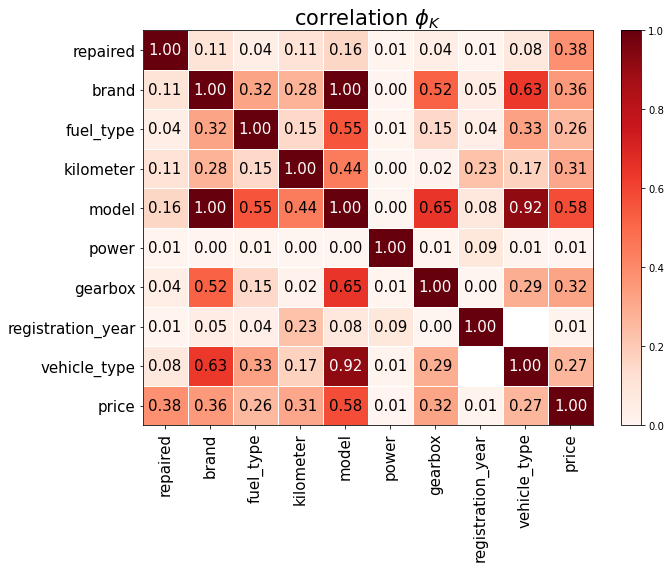

In [11]:
plot_correlation_matrix(phik_overview.to_numpy(),
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

In [12]:
df = df.drop(df[df['power']>250].index).reset_index(drop=True)

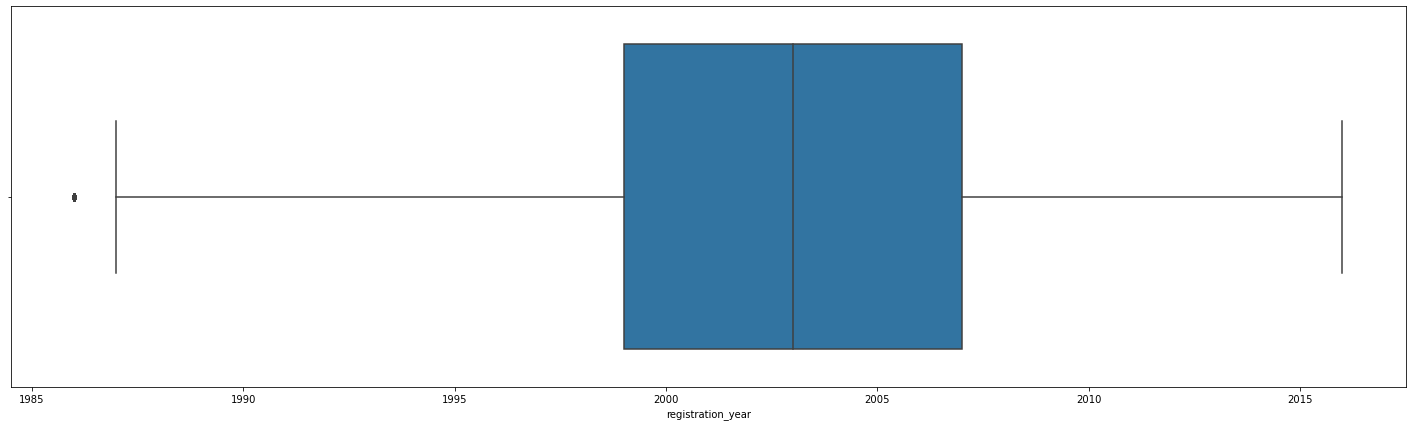

In [13]:
plt.figure(figsize=(25,7))
sns.boxplot(x=df.query('registration_year > 1985 & registration_year <= 2016')['registration_year'])
plt.show()

In [14]:
df = df.drop(df[(df['registration_year']>2016) | (df['registration_year'] < 1985)].index).reset_index(drop=True)

In [15]:
df.describe(include='all')

date_crawled          price vehicle_type  registration_year  \
count                327304  327304.000000       305289      327304.000000   
unique               255899            NaN            8                NaN   
top     2016-03-24 14:49:47            NaN        sedan                NaN   
freq                      5            NaN        86682                NaN   
mean                    NaN    4313.551148          NaN        2002.941874   
std                     NaN    4406.433477          NaN           5.898024   
min                     NaN       0.000000          NaN        1985.000000   
25%                     NaN    1000.000000          NaN        1999.000000   
50%                     NaN    2690.000000          NaN        2003.000000   
75%                     NaN    6200.000000          NaN        2007.000000   
max                     NaN   20000.000000          NaN        2016.000000   

       gearbox          power   model      kilometer  registration_month  \
count   310556  327304.000000  311322  327304.000000       327304.000000   
unique       2            NaN     246            NaN                 NaN   
top     manual            NaN    golf            NaN                 NaN   
freq    252472            NaN   27207            NaN                 NaN   
mean       NaN     104.036669     NaN  128548.994207            5.770513   
std        NaN      56.113655     NaN   37418.457547            3.708049   
min        NaN       0.000000     NaN    5000.000000            0.000000   
25%        NaN      69.000000     NaN  125000.000000            3.000000   
50%        NaN     105.000000     NaN  150000.000000            6.000000   
75%        NaN     140.000000     NaN  150000.000000            9.000000   
max        NaN     250.000000     NaN  150000.000000           12.000000   

       fuel_type       brand repaired         date_created  \
count     301509      327304   265196               327304   
unique         7          40        2                  107   
top       petrol  volkswagen       no  2016-04-03 00:00:00   
freq      200942       71651   231376                12705   
mean         NaN         NaN      NaN                  NaN   
std          NaN         NaN      NaN                  NaN   
min          NaN         NaN      NaN                  NaN   
25%          NaN         NaN      NaN                  NaN   
50%          NaN         NaN      NaN                  NaN   
75%          NaN         NaN      NaN                  NaN   
max          NaN         NaN      NaN                  NaN   

        number_of_pictures    postal_code            last_seen  
count             327304.0  327304.000000               327304  
unique                 NaN            NaN               169207  
top                    NaN            NaN  2016-04-07 08:16:54  
freq                   NaN            NaN                   16  
mean                   0.0   50582.329901                  NaN  
std                    0.0   25783.735620                  NaN  
min                    0.0    1067.000000                  NaN  
25%                    0.0   30169.000000                  NaN  
50%                    0.0   49479.000000                  NaN  
75%                    0.0   71116.000000                  NaN  
max                    0.0   99998.000000                  NaN

In [16]:
#df.isna().sum()
df = df.drop(df[df['price'] == 0].index).reset_index(drop=True)

In [17]:
df = df.fillna(value = 'not_specified')

In [18]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [19]:
features = df.drop(['date_crawled','registration_month','date_created','postal_code','last_seen','number_of_pictures','price'], axis=1)
target = df['price']

In [20]:
features

vehicle_type  registration_year        gearbox  power          model  \
0       not_specified               1993         manual      0           golf   
1               coupe               2011         manual    190  not_specified   
2                 suv               2004           auto    163          grand   
3               small               2001         manual     75           golf   
4               small               2008         manual     69          fabia   
...               ...                ...            ...    ...            ...   
317909            bus               2000         manual      0         zafira   
317910  not_specified               2005  not_specified      0  not_specified   
317911    convertible               2000           auto    101         fortwo   
317912            bus               1996         manual    102    transporter   
317913          wagon               2002         manual    100           golf   

        kilometer      fuel_type           brand       repaired  
0          150000         petrol      volkswagen  not_specified  
1          125000       gasoline            audi            yes  
2          125000       gasoline            jeep  not_specified  
3          150000         petrol      volkswagen             no  
4           90000       gasoline           skoda             no  
...           ...            ...             ...            ...  
317909     150000         petrol            opel             no  
317910      20000  not_specified  sonstige_autos  not_specified  
317911     125000         petrol           smart             no  
317912     150000       gasoline      volkswagen             no  
317913     150000       gasoline      volkswagen  not_specified  

[317914 rows x 9 columns]

In [21]:
encoder = OrdinalEncoder(dtype='int16')

In [22]:
encoder.fit(features)

OrdinalEncoder(dtype='int16')

In [23]:
features_encodered = pd.DataFrame(encoder.transform(features), columns=features.columns)

In [24]:
features_encodered

vehicle_type  registration_year  gearbox  power  model  kilometer  \
0                  3                  8        1      0    116         12   
1                  2                 26        1    190    161         11   
2                  7                 19        0    163    117         11   
3                  6                 16        1     75    116         12   
4                  6                 23        1     69    101          9   
...              ...                ...      ...    ...    ...        ...   
317909             0                 15        1      0    246         12   
317910             3                 20        2      0    161          2   
317911             1                 15        0    101    106         11   
317912             0                 11        1    102    221         12   
317913             8                 17        1    100    116         12   

        fuel_type  brand  repaired  
0               7     38         1  
1               2      1         2  
2               2     14         1  
3               7     38         0  
4               2     31         0  
...           ...    ...       ...  
317909          7     24         0  
317910          5     33         1  
317911          7     32         0  
317912          2     38         0  
317913          2     38         1  

[317914 rows x 9 columns]

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 

Для линейных моделей прямое кодирование отлично подойдет 👍
</div>

In [25]:
STATE = np.random.seed(42)

In [26]:
features_encodered_train, features_encodered_test, target_train, target_test = train_test_split(
    features_encodered, target, test_size=0.10, random_state=STATE)

### Вывод по разделу

- отбросил выбросу по мощности двигателя машины и даты регистрации в размере 3% от размера дата сета
- пропуски обработаны заменой на значение 'not_specified', т.к. модель должна в будущем уметь обрабатывать пропуски
- для обучения моделей в будущем применил OrdinalEncoder преобразование категориальных фичей

## Обучение моделей

### LGBMRegressor

In [27]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.01,
    'verbose': 100,
    "max_depth": 5,
    "num_leaves": 31,  
    "max_bin": 512,
    'n_jobs': -1,
    'random_state':STATE,
    'metric': 'rmse'
}

In [28]:
lgb_train = lgb.Dataset(data=features_encodered_train, label=target_train)

In [29]:
%%time
cv = lgb.cv(params,
        lgb_train,
        num_boost_round=10_000,
        early_stopping_rounds=15,
        stratified=False,
        verbose_eval=200) 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.746625
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.189640
[LightGBM] [Debug] init for col-wise cost 0.004747 seconds, init for row-wise cost 0.005320 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the

In [30]:
print("RMSE: %.2f" % pd.Series(cv['rmse-mean']).mean())

RMSE: 1568.46


### RandomForestRegressor

In [42]:
model = None
best_result = 10_000

In [43]:
%%time
param_grid = {'n_estimators': list(range(1, 15)), 'max_depth': list(range(1, 15))}
params = list(ParameterGrid(param_grid))
for param in tqdm(params):
    model = RandomForestRegressor(random_state=STATE, n_estimators=param['n_estimators'], max_depth=param['max_depth'], n_jobs=-1)
    scores = abs(cross_val_score(model, features_encodered_train, target_train, cv=5, error_score='raise', n_jobs= -1, scoring='neg_mean_squared_error'))
    final_score = (sum(scores) / len(scores))**0.5 
    if final_score < best_result:
        best_result = final_score
        best_model = model  

  0%|          | 0/196 [00:00<?, ?it/s]

3446.6968514700025
3446.6717972279807
3446.6304852612398
3446.619737643293
3022.378018629715
2984.750651906096
2984.6338572683903
2972.8219037936997
2968.0126763150006
2746.5688467784807
2681.4387360412197
2674.5123114671737
2664.4374558907607
2660.503121197385
2658.7808061790633
2455.769772840597
2409.1825661640414
2402.1604674221994
2401.524211097579
2383.77628388906
2378.9281334718085
2373.748414034673
2372.249887226953
2366.3274217431795
2311.9496817822437
2271.1111899395987
2254.970050691673
2254.344060329891
2248.5531492986347
2245.881272431926
2182.9137868892085
2151.2317572056777
2144.1283956481698
2131.7796384577196
2129.8378045536265
2123.7079514881448
2119.328517032397
2092.10051184312
2060.387632619608
2034.1232365180292
2030.8627055785385
2025.988680909072
2025.8321602629253
2022.2669929580202
2021.0296516528633
2019.5517891288355
2016.060014320895
1968.3644492561336
1962.237064520255
1953.6702936915167
1946.8750252501663
1945.3172569171027
1944.4151295156294
1943.21773798

In [45]:
print('Лучшая модель:',best_model)
print("RMSE: %.2f" % final_score) 

Лучшая модель: RandomForestRegressor(max_depth=14, n_estimators=13, n_jobs=-1)
RMSE: 1591.13


### Вывод по разделу

- использовались две модели: градиентный бустинг LightGBM и RFRegressor
- метика качетва LightGBM оказалась чуть лучше чем у RFRegressor

## Тестирование

### RandomForestRegressor

In [ ]:
model = best_model

In [ ]:
%%time
model.fit(features_encodered_train, target_train)

In [ ]:
%%time
predicted_test = model.predict(features_encodered_test)

In [ ]:
rmse = mean_squared_error(target_test, predicted_test)**(0.5)

In [ ]:
print('Лучшая модель:',best_model)
print("RMSE на тестовой выборке: %.2f" % rmse) 

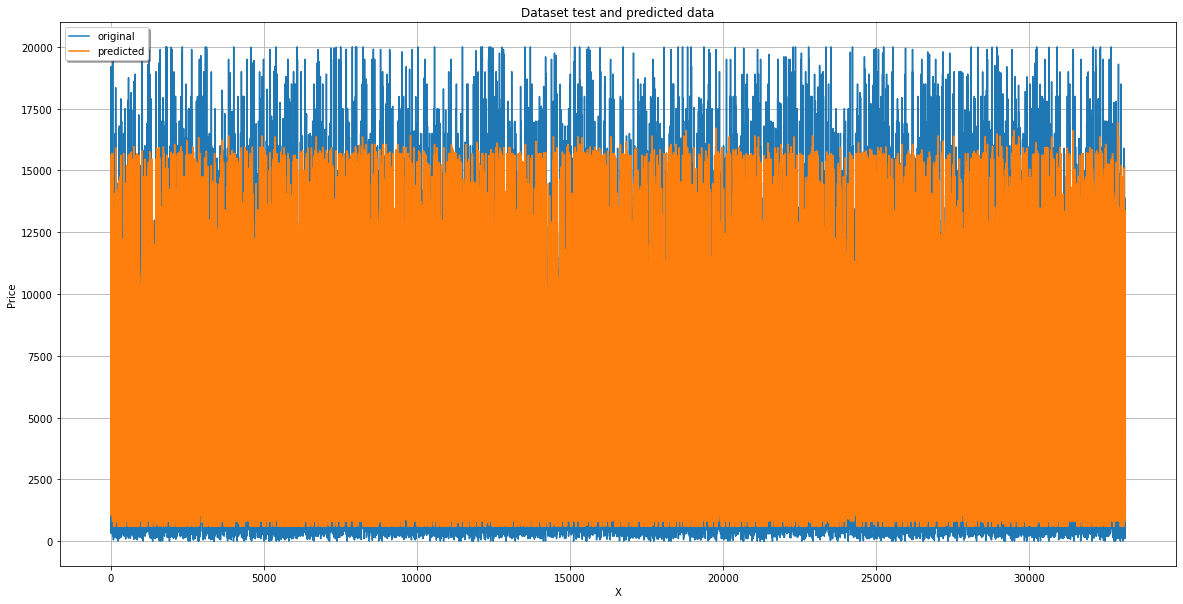

In [ ]:
x_ax = range(len(target_test))
plt.figure(figsize=(20, 10))
plt.plot(x_ax, target_test, label="original")
plt.plot(x_ax, predicted_test, label="predicted")
plt.title("Dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### LGBMRegressor

In [49]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.01,
    'verbose': 10,
    "max_depth": 5,
    "num_leaves": 31,  
    "max_bin": 512,
    "num_iterations": 10_000,
    'n_jobs':-1,
    'random_state':STATE
}

In [50]:
model = lgb.LGBMRegressor(**params)

In [51]:
%%time
model.fit(features_encodered_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.746625
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.189640
[LightGBM] [Debug] init for col-wise cost 0.004882 seconds, init for row-wise cost 0.004550 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 286122, number of used features: 9
[LightGBM] [Info] Start training from score 4435.561107
[LightGBM] [Debug] Trained 

LGBMRegressor(learning_rate=0.005, max_bin=512, max_depth=5,
              num_iterations=5000, objective='regression', task='train',
              verbose=10)

In [52]:
%%time
y_pred = model.predict(features_encodered_test)

CPU times: total: 35.6 s
Wall time: 3.32 s


In [53]:
rmse = mean_squared_error(target_test, y_pred)**(0.5)

In [54]:
print('Лучшая модель:',model)
print("RMSE на тестовой выборке: %.2f" % rmse) 

Лучшая модель: LGBMRegressor(learning_rate=0.005, max_bin=512, max_depth=5,
              num_iterations=5000, objective='regression', task='train',
              verbose=10)
RMSE на тестовой выборке: 1546.57


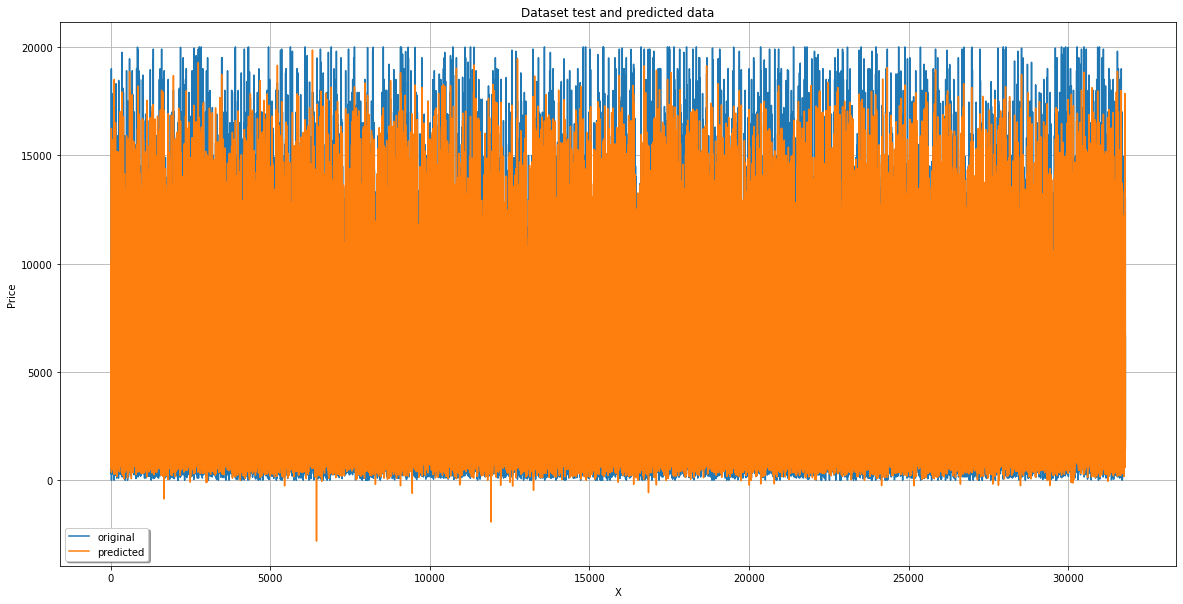

In [55]:
x_ax = range(len(target_test))
plt.figure(figsize=(20, 10))
plt.plot(x_ax, target_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### Вывод

RandomForestRegressor
- лучшая модель RandomForestRegressor(max_depth=9, n_estimators=9)
- лучшее значение RMSE на тестовой выборке 1895.66
- время обучения 893 ms и время предсказаний 10 ms

LGBMRegressor
- лучшая модель LGBMRegressor(learning_rate=0.05, max_bin=100, max_depth=20, num_iterations=3000, num_leaves=30, objective='regression', task='train')
- лучшее значение RMSE на тестовой выборке 1455.52
- время обучения 10.4 s и время предсказаний 589 ms

# Вывод

- отбросил выбросу по мощности двигателя машины и даты регистрации в размере 3% от размера дата сета
- пропуски обработаны заменой на значение 'not_specified', т.к. модель должна в будущем уметь обрабатывать пропуски
- для обучения моделей в будущем применил OrdinalEncoder преобразование категориальных фичей

- использовались две модели: градиентный бустинг LightGBM и RFRegressor
- метика качества LightGBM оказалась чуть лучше чем у RFRegressor

Результаты на тестовой выборке:

RandomForestRegressor
- лучшая модель RandomForestRegressor(max_depth=9, n_estimators=9)
- лучшее значение RMSE 1895.66
- время обучения 893 ms и время предсказаний 10 ms

LGBMRegressor
- лучшая модель LGBMRegressor(learning_rate=0.05, max_bin=100, max_depth=20, num_iterations=3000, num_leaves=30, objective='regression', task='train')
- лучшее значение RMSE  1455.52
- время обучения 10.4 s и время предсказаний 589 ms

Метрика RMSE у LGBMRegressor лучше чем у RandomForestRegressor на 30%, но время предсказания дольше в 59 раз. Поэтому итоговый выбор модели остается на усмотрение заказчика.

<div class="alert alert-block alert-info">
<b>Комментарий ревьюера:</b>

Чтобы все было ясно, напишу конкретный план (структуру) обучения и анализа моделей:

1. Обучение моделей. В обучении нужно рассмотреть хотя бы одну простую модель и один бустинг. Подбор гиперпараметров нужно провести хотя бы одной модели. Тут есть два варианта:
    - без валидационной выборки. Здесь нужно подбирать гиперпараметры с помощью кросс-валидации (GridSearchCV, RandomizedSearchCV или вручную (cross_val_score));
    - валидационная выборка есть. Здесь можно не использовать кросс-валидацию и подбирать гиперпараметры вручную.  
2. Анализ моделей. После нахождения лучших гиперпараметров стоит измерить время обучения, предсказания и RMSE. Тут тоже есть два варианта:
    - без валидационной выборки. RMSE на кросс-валидации. Время обучения = время model.fit(X_train). Время предсказания  = model.predict(X_train);
    - валидационная выборка есть. RMSE на validation. Время обучения = время model.fit(X_train). Время предсказания = время model.predict(X_valid).  
    
    После этого напиши вывод по анализу (можешь также результаты моделей занести в общую таблицу) и посоветуй заказчику одну модель на основе его критериев;
3. Тестирование. Рассчитай финальную метрику лучшей модели на тестовой выборке (до этого тестовая выборка нигде не должна использоваться!). RMSE должно быть меньше 2500. Если метрика не дотягивает, попробуй исправить мои замечания, также можешь потюнить гиперпараметры (на этапе обучения моделей, не на тестовой выборке!)
</div>